# Исследование надёжности заёмщиков

**Заказчик:** кредитный отдел банка. 

**Цель:** определение влияния различных факторов (таких как семейного положения и количество детей клиента) на факт погашения кредита в срок. 

**Входные данные от банка**: статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Содержание

* [Предобработка и исследовательский анализ данных (EDA)](#chapter1)
    * [Описание датасета](#section_1_1)
    * [Предобработка данных](#section_1_2)
* [Лемматизация](#chapter2)
* [Категоризация](#chapter3)
* [Исследование надежности заемщиков](#chapter4)
    * [Зависимость между наличием детей и возвратом кредита в срок](#section_4_1)
    * [Зависимость между семейным положением и возвратом кредита в срок](#section_4_2)
    * [Зависимость между уровнем дохода и возвратом кредита в срок](#section_4_3)    
    * [Влияние цели получения кредита на его возврат в срок](#section_4_4)
* [Общие выводы](#chapter5)   


## Предобработка и исследовательский анализ данных (EDA) <a class="anchor" id="chapter1"></a>

### Описание датасета <a class="anchor" id="section_1_1"></a>

In [1]:
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [2]:
df.shape

(21525, 12)

In [3]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [4]:
# переимением столбец `dob_years` в `age` для простоты восприятия и длины строки
df.columns = ['children', 'days_employed', 'age', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose']

In [5]:
df.head()

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


В исследуемой выборке 21 525 строк - клиентов, данными о которых мы располагаем для анализа.  

Датасет содержит данные о следующих параметрах:
 - `children` количество детей в семье;
 - `days_employed` продолжительность трудового стажа в днях (есть пропуски в данных);
 - `age` возраст клиента в годах;
 - `education` уровень образования;
 - `education_id` идентификатор уровня образования;
 - `family_status` семейное положение;
 - `family_status_id` идентификатор семейного положения;
 - `gender` - пол (F - женский; M - мужской);
 - `income_type` тип занятости;
 - `debt` - имел ли задолженность по возврату кредитов;
 - `total_income` ежемесячный доход (наличие пропусков);
 - `purpose` цель получения кредита.
 
Ключевой параметр, который нас интересует параментр - `debt` (возврат кредита в срок), определение факта влияния различных критериев на заданный парамент позможет в дальнейшем выстроить эффективную систему скорринга для банка.

### Предобработка данных <a class="anchor" id="section_1_2"></a>

In [6]:
df.duplicated().sum()

54

В выборке 71 дубликат, выборку очистим.

In [7]:
df = df.drop_duplicates().reset_index(drop = True)
df.shape

(21471, 12)

В датасете обнаружен 71 дубликат, в случае с выгрузкой из базы данных банка, дубликаты могли появиться при смене статуса рассмотрения заявки или стать результатом простой ошибки выгрузки. Во избежание ошибки и двойного учета, дубликаты удалены.

##### Количество детей

In [8]:
df['children'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Значение "-1" и "20" в графе колиечество детей вызывают сомнения. Наиболее верояно, данные являются ошибкой ввода: "-1" вместо "1", "20" вместо "2". Так как количество детей обычно колеблется от 0 до 5, что подтверждается выборкой (наибольшее количество людей не имеют детей или имеют 1 ребенка, 5 детей у наименьшего количества людей), исправим ошибку заменой.

In [9]:
df['children'] = df['children'].replace(-1, 1)
df['children'] = df['children'].replace(20, 2)

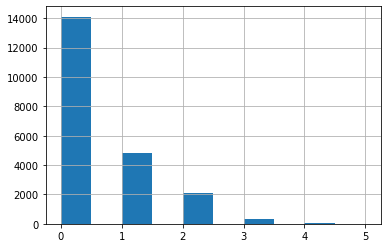

In [10]:
# оценим распределение количества детей в семье
df['children'].hist()

##### Трудовой стаж

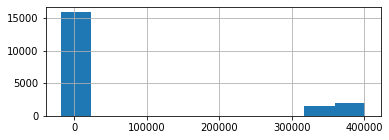

In [11]:
# Гистограмма расплеределения трудового стажа
df['days_employed'].hist(figsize = (6, 2))

In [12]:
df[df['days_employed'] < 0]['days_employed'].count()

15906

Значения в столбце `data_employed` отрицательные (74% всех значений), возможно ошибка, но пояснения отсутствуют. Так как в датасете есть параметры возраста, образования и дохода, ответить на ключевые вопросы можно без использования данных из данного столбца.

In [13]:
# удалим столбец с некорректными данными
df.drop('days_employed', axis = 1, inplace = True)

##### Возраст

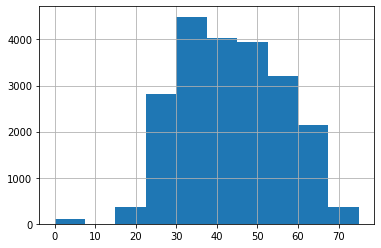

In [14]:
# Гистограмма расплеределения возраста
df['age'].hist()

In [15]:
print('Минимальный возраст в выборке -', df['age'].min())
print('Максимальный возраст в выборке -',df['age'].max())
print('Средний возраст в выборке -',df['age'].mean())
print('Средний возраст в выборке (медианное значение) -',df['age'].median())

Минимальный возраст в выборке - 0
Максимальный возраст в выборке - 75
Средний возраст в выборке - 43.279074099948765
Средний возраст в выборке (медианное значение) - 42.0


In [16]:
print('В выборке', df[df['age'] < 18]['age'].count(), 'строка с некорректным возрастом.')

В выборке 101 строка с некорректным возрастом.


In [17]:
# 101 просуск составляет 0,5%, оставим только корректные данные
df = df[df['age'] != 0]

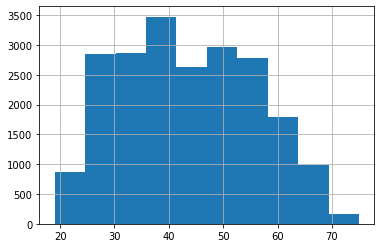

In [18]:
df['age'].hist()

##### Образование

In [19]:
df['education'].value_counts()

среднее                13646
высшее                  4678
СРЕДНЕЕ                  770
Среднее                  708
неоконченное высшее      666
ВЫСШЕЕ                   272
Высшее                   266
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [20]:
# приведем данные в столбце образование к нижнему регистру
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [21]:
df['education'].isna().sum()

0

Данные приведены к нижнему регистру и теперь имеют единый вид. Пропуски по данному полю отсутствуют.

##### Семейное положение

In [22]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [23]:
df['family_status'].isna().sum()

0

Пропуски отсутствуют, статусы корректны.

##### Пол

In [24]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [25]:
# в датафрейме всего 1 строка с некорректным полом, уберем данные всей строки их анализа
df = df[df['gender'] != "XNA"]

##### Тип занятости и ежемесячный доход

In [26]:
df['income_type'].value_counts()

сотрудник          11036
компаньон           5059
пенсионер           3817
госслужащий         1451
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

In [27]:
print('Минимальный уровень дохода в выборке -', df['total_income'].min())
print('Максимальный уровень дохода в выборке -',df['total_income'].max())
print('Средний уровень дохода в выборке -',df['total_income'].mean())
print('Средний уровень дохода в выборке (медианное значение) -',df['total_income'].median())
print('Количество пропусков в выборке -',df['total_income'].isna().sum())

Минимальный уровень дохода в выборке - 20667.26379327158
Максимальный уровень дохода в выборке - 2265604.028722744
Средний уровень дохода в выборке - 167463.33199560302
Средний уровень дохода в выборке (медианное значение) - 145005.48105850274
Количество пропусков в выборке - 2110


In [28]:
# рассчитаем средний уровень дохода по типу дохода
df.groupby('income_type')['total_income'].mean()

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        171008.225815
компаньон          202483.170111
пенсионер          137120.690001
предприниматель    499163.144947
сотрудник          161404.247418
студент             98201.625314
Name: total_income, dtype: float64

In [29]:
missed = df[df['total_income'].isnull()]
missed['income_type'].value_counts(normalize=True)

сотрудник          0.508057
компаньон          0.237441
пенсионер          0.185308
госслужащий        0.068720
предприниматель    0.000474
Name: income_type, dtype: float64

Существуют пропуски в данных среди представителей большинства типов занятости.

In [30]:
df['income_type'].value_counts(normalize=True)

сотрудник          0.516449
компаньон          0.236745
пенсионер          0.178623
госслужащий        0.067902
безработный        0.000094
предприниматель    0.000094
студент            0.000047
в декрете          0.000047
Name: income_type, dtype: float64

Проверели есть ли связь между пропущенными значениями в графе `total_income` и `income_type`, в качестве проверке гиппотезы о том, что люди с высоким доходом предпочитают его не афишировать. Мы видим, что и в данных с пропусками, и в общих данных концентрация типов занятости одинаковая, то есть пропуски не зависят от типа занятости. Пропуски в поле доход обнаружены у людей со следующим видом дохода: "сотрудник", "компаньон", "пенсионер", "госслужащий" и "предприниматель". В списке тип дохода, подразумевает регулярное денежное вознаграждение. Возможно данные скрыты преднамерено, но доля пропущенных значение соответствует доле соответствующих профессий в общем датасете. 
Заменим обнаруженные пропуски медианным значением по типу дохода.

In [31]:
# заменим пропущенные значения в выборке средним (медианным) значением по источнику дохода

for income_type_name in df['income_type'].unique():
    df.loc[(df['income_type'] == income_type_name)
           & (df['total_income'].isna()),'total_income']  = df.loc[(df['income_type'] == income_type_name),
                                                                   'total_income'].median()
    

In [32]:
print('Новое количество пропусков с толбце доход в данных -', df['total_income'].isna().sum())

Новое количество пропусков с толбце доход в данных - 0


In [33]:
df['total_income'].astype('int')

0        253875
1        112080
2        145885
3        267628
4        158616
          ...  
21466    224791
21467    155999
21468     89672
21469    244093
21470     82047
Name: total_income, Length: 21369, dtype: int64

Данные прошли предварительную обработку. 
Некорректные значение в столбце количество детей (`children`) заменено корректными.
Строки в столбце `education` приведены к единому регистру.
Уровень дохода (`total_imcome`) - важный критерий, без которого невозможно ответить на поставленные вопросы. Пропущенные данные в нем заменены средним значением по типу достатка.
В графе `gender` было значение с ошибкой, строку с неверными данными мы опустили.

##### Цели получения кредита

In [34]:
# приведем значения цели получения кредита к единому нижнему регистру для дальнейшей работе с текстом

df['purpose'].astype('str').str.lower()

0                       покупка жилья
1             приобретение автомобиля
2                       покупка жилья
3          дополнительное образование
4                     сыграть свадьбу
                     ...             
21466               операции с жильем
21467            сделка с автомобилем
21468                    недвижимость
21469    на покупку своего автомобиля
21470           на покупку автомобиля
Name: purpose, Length: 21369, dtype: object

Данные в столбце `purpose` приведены к единому регистру.

In [35]:
# повторная проверка на дубликаты после привещения датафрейма к нижнему регистру
df.duplicated().sum()

17

In [36]:
df = df.drop_duplicates().reset_index(drop = True)
df.shape

(21352, 11)

## Лемматизация <a class="anchor" id="chapter2"></a>

Для создания словаря целей получения кредита применем лемматизацию.

In [37]:
from pymystem3 import Mystem
m = Mystem()

#добавим столбец с лемматизированными данными в датафрейм
df['purpose_lem'] = df['purpose'].apply(m.lemmatize)

df[['purpose', 'purpose_lem']]

,purpose,purpose_lem
0,покупка жилья,"[покупка, , жилье, \n]"
1,приобретение автомобиля,"[приобретение, , автомобиль, \n]"
2,покупка жилья,"[покупка, , жилье, \n]"
3,дополнительное образование,"[дополнительный, , образование, \n]"
4,сыграть свадьбу,"[сыграть, , свадьба, \n]"
...,...,...
21347,операции с жильем,"[операция, , с, , жилье, \n]"
21348,сделка с автомобилем,"[сделка, , с, , автомобиль, \n]"
21349,недвижимость,"[недвижимость, \n]"
21350,на покупку своего автомобиля,"[на, , покупка, , свой, , автомобиль, \n]"


In [38]:
from pymystem3 import Mystem
from collections import Counter
m = Mystem()

test = Counter(m.lemmatize(' '.join(df['purpose'])))
test.most_common(20)


[(' ', 54785),
 ('недвижимость', 6327),
 ('покупка', 5869),
 ('жилье', 4436),
 ('автомобиль', 4284),
 ('образование', 3995),
 ('с', 2904),
 ('операция', 2593),
 ('свадьба', 2310),
 ('свой', 2223),
 ('на', 2210),
 ('строительство', 1873),
 ('высокий', 1366),
 ('получение', 1309),
 ('коммерческий', 1306),
 ('для', 1286),
 ('жилой', 1224),
 ('сделка', 938),
 ('дополнительный', 902),
 ('заниматься', 900)]

Среди наиболее часто встречающихся целей получения кредита можно выделить: "недвижимость", "жилье", "автомобиль", "образование" и "свадьба". "Недвижимость" и "жилье" мы выделим в отдельные группы, так как недвижимость может быть коммерческой и приобретена с целью создания коммерческих организаций.

In [39]:
# выделим основные цели получения кредитов
def purpose_group(purpose_lem):
    if 'жилье' in purpose_lem:
        return 'жилье'
    if 'недвижимость' in purpose_lem:
        return 'недвижимость'
    if 'автомобиль' in purpose_lem:
        return 'автомобиль'
    if 'свадьба' in purpose_lem:
        return 'свадьба'
    if 'образование' in purpose_lem:
        return 'образование'
    return 'другое'

# выделим цели в отдельный столбец и добавим в датафрейм
df['purpose_group'] = df['purpose_lem'].apply(purpose_group)

# проверим результат
df[['purpose', 'purpose_lem','purpose_group']]

,purpose,purpose_lem,purpose_group
0,покупка жилья,"[покупка, , жилье, \n]",жилье
1,приобретение автомобиля,"[приобретение, , автомобиль, \n]",автомобиль
2,покупка жилья,"[покупка, , жилье, \n]",жилье
3,дополнительное образование,"[дополнительный, , образование, \n]",образование
4,сыграть свадьбу,"[сыграть, , свадьба, \n]",свадьба
...,...,...,...
21347,операции с жильем,"[операция, , с, , жилье, \n]",жилье
21348,сделка с автомобилем,"[сделка, , с, , автомобиль, \n]",автомобиль
21349,недвижимость,"[недвижимость, \n]",недвижимость
21350,на покупку своего автомобиля,"[на, , покупка, , свой, , автомобиль, \n]",автомобиль


In [40]:
df['purpose_group'].value_counts()

недвижимость    6327
жилье           4436
автомобиль      4284
образование     3995
свадьба         2310
Name: purpose_group, dtype: int64

In [41]:
df['purpose_group'].value_counts(normalize = True)

недвижимость    0.296319
жилье           0.207756
автомобиль      0.200637
образование     0.187102
свадьба         0.108187
Name: purpose_group, dtype: float64

### Вывод

С помощью лемматизации среди целей получения кредита выделены 5 основных: недвижимость, жилье, автомобиль, образование и свадьба. Наибольшее количество людей берут кредит для покупки или ремонта недвижимости (30%), а также на жилье (21%), что также может относиться к недвижимости. Тройку лидеров закрывает автомобиль, для приобритения его кредит берут 20% клиентов.
Определение целей позволит произвести группировку для дальнейшего анализа.

## Категоризация <a class="anchor" id="chapter3"></a>

#### Возрастные категории

In [42]:
# выделим группы по возрасту
def age_group (age):
    if age < 18:
        return "wrong"
    if age <= 35:
        return "18 - 35"
    if age <= 45:
        return "36 - 45"
    if age <= 65:
        return "46 - 65"
    return "66 - 75"

# добавим тип групп в датафрейм
df['age_group'] = df['age'].apply(age_group)
df.sample(2)

,children,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lem,purpose_group,age_group
9884,1,45,начальное,3,Не женат / не замужем,4,M,сотрудник,0,298488.469580,заняться высшим образованием,"[заниматься, , высокий, , образование, \n]",образование,36 - 45
13841,0,28,высшее,0,Не женат / не замужем,4,F,компаньон,0,172268.927048,операции с коммерческой недвижимостью,"[операция, , с, , коммерческий, , недвижимо...",недвижимость,18 - 35


In [43]:
df.groupby('age_group')['age_group'].count()

age_group
18 - 35    6582
36 - 45    5620
46 - 65    8448
66 - 75     702
Name: age_group, dtype: int64

Благодаря группировке, мы получили 4 возрастные группы, 3 из которых позволяют разделить взрослых клиентов на практически равные группы и выделить одну группу пенсионеров.

#### Категории по уровню дохода

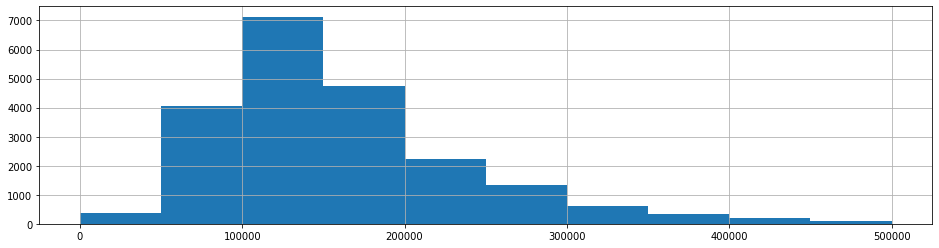

In [44]:
df['total_income'].hist(figsize = (16, 4), bins = 10, range = (0, 500000))

In [45]:
# категориии по уровню дохода
def income_group (income):
    if income <= 50000:
        return 'менее 50k'
    if income <= 100000:
        return '50k - 100k'
    if income <= 200000:
        return '100k - 200k'    
    if income <= 300000:
        return '200k - 300k'
    if income <= 500000:
        return '300k - 500k'
    return 'более 500k'

# добавим столбец с категориями в датафрейм
df['income_group'] = df['total_income'].apply(income_group)

In [46]:
df.groupby('income_group')['income_group'].count()

income_group
100k - 200k    11872
200k - 300k     3561
300k - 500k     1257
50k - 100k      4070
более 500k       222
менее 50k        370
Name: income_group, dtype: int64

#### Категории по семейному положению

In [47]:
#выделим семейное положение в отдельный датафрейм
df_log = df[['family_status','family_status_id']]
df_log['family_status'].value_counts(3)

женат / замужем          0.575590
гражданский брак         0.193378
Не женат / не замужем    0.130854
в разводе                0.055498
вдовец / вдова           0.044680
Name: family_status, dtype: float64

In [61]:
# создадим словарь, оставив только уникальные значения в датафрейме с семейным пложением
df_dict = df_log.drop_duplicates().reset_index(drop = True)
df_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


### Вывод

Для категоризации были определены группы по следующим критериям: 
1. Возрастные группы
2. Группы по уровню дохода
Таже ранее были присвоены группы по целям получения кредите.

Категоризация позволяет разделять выборку для определения общих признаков и ответа на вопросы.

## Исследование надежности заемщиков <a class="anchor" id="chapter4"></a>

In [57]:
df.corr()

,children,age,education_id,family_status_id,debt,total_income
children,1.000000,-0.318035,-0.026519,-0.158089,0.025019,0.031668
age,-0.318035,1.000000,0.064745,-0.068807,-0.071579,-0.060523
education_id,-0.026519,0.064745,1.000000,0.009524,0.052786,-0.172049
family_status_id,-0.158089,-0.068807,0.009524,1.000000,0.020686,-0.008451
debt,0.025019,-0.071579,0.052786,0.020686,1.000000,-0.012573
total_income,0.031668,-0.060523,-0.172049,-0.008451,-0.012573,1.000000


Отсутствует прямая выраженная корреляция между признаками.

### Зависимость между наличием детей и возвратом кредита в срок  <a class="anchor" id="section_4_1"></a>

In [49]:
df_pivot_kids = df.pivot_table(index=['children'], columns=['gender'], values='debt', aggfunc= {'mean', 'count'})

df_pivot_kids.reset_index()

children   count              mean          
gender                F       M         F         M
0             0  9470.0  4551.0  0.062196  0.103054
1             1  3109.0  1730.0  0.078482  0.114451
2             2  1293.0   821.0  0.106729  0.077954
3             3   195.0   133.0  0.087179  0.075188
4             4    28.0    13.0  0.035714  0.230769
5             5     7.0     2.0  0.000000  0.000000

In [50]:
df.groupby('children').agg({'debt': ['mean', 'count']})

debt       
              mean  count
children                 
0         0.075458  14021
1         0.091341   4839
2         0.095553   2114
3         0.082317    328
4         0.097561     41
5         0.000000      9

*Вероятность задолженности повышается с появлением детей*

#### Вывод

Зависимость между количеством детей и возвратом кредита в срок разная среди мужчин и женщин. 
Так, **женщины, у которых детей нет, реже имеют задолженность по кредиту**. Женщины с двумя детьми чаще имеют задолженность, чем матери 1 ребенка. Среди женщин с 3 и более детьми данных о возврате немного для однозначных выводов, однако динамика сохраняется: *чем больше детей, тем выше вероятность задолженности*. Однако, среди матерей 5 детей задолженности по кредиту нет.
Среди мужчин, задолженность по кредиту **реже именют отцы 2 детей**, в то время как родители 1 ребенка и мужчины без детей чаще имеют задолженность по кредиту.


### Зависимость между семейным положением и возвратом кредита в срок  <a class="anchor" id="section_4_2"></a>

In [51]:
df.groupby('family_status').agg({'debt': ['mean', 'count']})

debt       
                           mean  count
family_status                         
Не женат / не замужем  0.097709   2794
в разводе              0.071730   1185
вдовец / вдова         0.064990    954
гражданский брак       0.093485   4129
женат / замужем        0.075427  12290

Вдовы реже имеют задолженности по кредиту (однако, таких очень мало), чаще других групп имеют задолженности не женатые и/или находящиеся в гражданском браке.

In [59]:
# проверим зависимость семейнойго положения и возрастной группы на возврат кредита в срок

df_pivot_family_mean = df.pivot_table(index=['family_status'], columns=['age_group'], values='debt', 
                                 aggfunc= 'mean', fill_value='')
df_pivot_family_count = df.pivot_table(index=['family_status'], columns=['age_group'], values='debt', 
                                 aggfunc= 'count', fill_value='')
print('Доля клиентов, имеющих задолженность по кредиту, %')
display(df_pivot_family_mean)
print()
print('Количество клиентов, имеющих задолженность по кредиту, чел.')
display(df_pivot_family_count)

Доля клиентов, имеющих задолженность по кредиту, %


age_group,18 - 35,36 - 45,46 - 65,66 - 75
family_status,,,,
Не женат / не замужем,0.118669,0.094139,0.069767,0.026667
в разводе,0.103448,0.059490,0.064171,0.102564
вдовец / вдова,0.100000,0.056818,0.066478,0.057554
гражданский брак,0.108555,0.103448,0.074576,0.048544
женат / замужем,0.100365,0.077546,0.058000,0.046243



Количество клиентов, имеющих задолженность по кредиту, чел.


age_group,18 - 35,36 - 45,46 - 65,66 - 75
family_status,,,,
Не женат / не замужем,1382,563,774,75
в разводе,232,353,561,39
вдовец / вдова,20,88,707,139
гражданский брак,1391,1160,1475,103
женат / замужем,3557,3456,4931,346


### Вывод

В целом, с возрастом вероятность просрочки в основном снижается.

1. Среди не *женатых* вероятность задолженности по кредиту наивысшая. Однако вероятность задолженности уменьшается с возрастом. 
2. Среди *разведенных*, задолженность реже у людей от 36 до 65, лица младше 35 и старше 66 имеют долг чаще.
3. *Вдовцами* чаще становятся после 46 лет имеют задолженность реже, чем овдовевшие раньше.
4. Среди лиц в *гражданском браке*, люди до 45 лет чаще имеют задолженности по возврату кредита.
5. Реже других имею задолженность по возврату *женатые люди* в возрасте 46 до 65 лет, среди наиболее многочисленных групп. Среди женатых вероятность задолженности линейно уменьшается с увеличеснием возраста.

### Зависимость между уровнем дохода и возвратом кредита в срок  <a class="anchor" id="section_4_3"></a>

In [53]:
df.groupby('income_group').agg({'debt': ['mean', 'count']})

debt       
                  mean  count
income_group                 
100k - 200k   0.086169  11872
200k - 300k   0.070486   3561
300k - 500k   0.073190   1257
50k - 100k    0.081081   4070
более 500k    0.063063    222
менее 50k     0.062162    370

Реже задолженность по кредиту имеют люди с достатком менее 50 тысяч и свыше 500 тысяч, однако количество людей с подобным достатком наименьшее. У людей с достатком от 100 до 500 тысяч, **вероятность не возврата кредита в срок уменьшается с увеличением дохода**.

In [54]:
# проверим зависимость с учетом образования

df_pivot_income = df.pivot_table(index=['income_group', 'education'], columns=[], values='debt', 
                                 aggfunc= {'mean','count'}, fill_value='')

df_pivot_income

count      mean
income_group education                            
100k - 200k  высшее               2750.0  0.057091
             начальное             149.0  0.140940
             неоконченное высшее   411.0  0.080292
             среднее              8559.0  0.094871
             ученая степень          3.0  0.000000
200k - 300k  высшее               1153.0  0.046834
             начальное              37.0  0.108108
             неоконченное высшее   154.0  0.123377
             среднее              2215.0  0.078555
             ученая степень          2.0  0.000000
300k - 500k  высшее                568.0  0.038732
             начальное               3.0  0.000000
             неоконченное высшее    51.0  0.098039
             среднее               635.0  0.102362
50k - 100k   высшее                571.0  0.061296
             начальное              78.0  0.076923
             неоконченное высшее   111.0  0.072072
             среднее              3309.0  0.084920
             ученая степень          1.0  0.000000
более 500k   высшее                142.0  0.056338
             неоконченное высшее    11.0  0.272727
             среднее                69.0  0.043478
менее 50k    высшее                 31.0  0.032258
             начальное              15.0  0.000000
             неоконченное высшее     3.0  0.000000
             среднее               321.0  0.068536

### Вывод

Люди с высшим образованием реже других имеют задолженность по кредиту, при любом уровне достатка. Люди с начальным образованием, наоборот, чаще других имеют задолженность по кредиту. Люди с ученой степенью задолженность не имеют.
Уровет дохода действительно влияет на возврат кредита в срок, однако, для улучшение модели скоринга следует учитывать дополнительные параметры, такие как, уровень оброзования, который также влияет на погашение кредита различным образом, при разном достатке.

### Влияние цели получения кредита на его возврат в срок  <a class="anchor" id="section_4_4"></a>

In [55]:
df.groupby('purpose_group')['debt'].agg({'mean','count'})

,mean,count
purpose_group,,
автомобиль,0.093371,4284
жилье,0.068981,4436
недвижимость,0.074759,6327
образование,0.092616,3995
свадьба,0.079654,2310


Кредиты на *жилье* возвращаю в срок чаще всего. Кредиты, целью которых была недвижимость и свадьба, также чаще возвращают в срок, более того, нежвижимость берут кредиты чаще всего.

In [56]:
# проверим, зависит ли задолженность от цели и пола клиента

df_pivot_purpose = df.pivot_table(index=['purpose_group', 'gender'], columns=[], values='debt', 
                                 aggfunc= {'mean','count'}, fill_value='')

df_pivot_purpose

count      mean
purpose_group gender                  
автомобиль    F       2842.0  0.081633
              M       1442.0  0.116505
жилье         F       2886.0  0.064449
              M       1550.0  0.077419
недвижимость  F       4170.0  0.061631
              M       2157.0  0.100139
образование   F       2652.0  0.078054
              M       1343.0  0.121370
свадьба       F       1552.0  0.068943
              M        758.0  0.101583

Женщины чаще мужчин берут кредиты и реже имеют задолженность по ним.
Реже всего женщины имеют задолженности по кредитам на недвижимость, в то время, как мужчины чаще имеют задолженность по кредитам на образование и автомобиль.

### Вывод

**Все гипотезы о зависимости возврата кредита от различных факторо подтвердились.**
Однако, для улучшения модели, следует рассматривать влияние нескольких факторов. Так, количество детей влияет по-разному на возврат кредита в срок среди мужчин и женщин, а люди разного возраста, но одинакового семейного положения, по-разному возвращают кредит. 
Несмотря на различные цели кредитов, люди с одинаковой частотой имеют задержки по кредитам на автомобили и образование, недвижимость и свадьбу, однако рассматривая в связке с гендером, можно заметить что женщиты чаще возвращают кредиты вовремя вне зависимости от назначения кредита.

## Общий вывод <a class="anchor" id="chapter5"></a>

Важным этапом анализа является предварительная обработка данных.
Для ответа на поставленные вопросы о наличие зависимости между возвратом кредите и наличием детей, семейным положением, доходом и целями получения кредита были категорезированы данные и рассмотрены вместе с дополнительными факторами. 
Каждая гипотеза подтвердилась, так на возврат кредита в срок действительно влиятет колчество детей и доход, семейное положени и цели. Однако для улучшения модели скоринга следует рассматривать совместное влияние вакторов, например, пола и количества детей.

*Много факторов влияют на возврат кредита в срок, среди которых не малую роль играет семейное положение клиента.
Так, с появлением детей появляется и вероятность просрочки кредита.
Люди, находящиеся или находившиеся в браке реже имеют  задолженность, чем не женатые и находящиеся в гражданском браке.
С возрастом вероятность задолженности снижается.
Доход имеет наибольшее влияние на возврат кредита в срок - чем доход выше, там ниже риск.
Чаще всего кредиты берут на недвижимость и реже всего имеют по ним задолженность. Чаще всего просрочки имеют клиенты с кредитами на автомобили, к мужчинам, в этой группе следует уделять особое внимание, так как у них вероятность задолженности выше..*